In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gnss_lib_py as glp
from gnss_lib_py.utils.coordinates import add_el_az
from gnss_lib_py.utils.dop import get_dop



In [2]:
sp3_path = "data/COD0MGXFIN_20211180000_01D_05M_ORB.SP3"
sp3 = glp.Sp3(sp3_path)
print(sp3)

        gps_millis gnss_sv_id gnss_id  sv_id        x_sv_m        y_sv_m  \
0     1.303668e+12        G01     gps      1  1.328768e+07 -1.549193e+07   
1     1.303668e+12        G02     gps      2 -1.344951e+07 -9.668544e+06   
2     1.303668e+12        G03     gps      3  2.258999e+07 -1.299617e+07   
3     1.303668e+12        G04     gps      4  1.514119e+07 -6.442989e+06   
4     1.303668e+12        G05     gps      5 -2.431371e+07  2.825648e+06   
...            ...        ...     ...    ...           ...           ...   
8463  1.303690e+12        C45  beidou     45 -2.192827e+07  1.712494e+06   
8464  1.303690e+12        C46  beidou     46 -1.358145e+07 -1.945488e+07   
8465  1.303690e+12        J01    qzss      1 -2.258361e+07  3.028899e+07   
8466  1.303690e+12        J02    qzss      2 -2.462862e+07  2.266367e+07   
8467  1.303690e+12        J03    qzss      3 -3.561799e+07  2.180851e+07   

            z_sv_m  
0     1.654569e+07  
1    -2.010071e+07  
2    -4.880224e+06  
3  

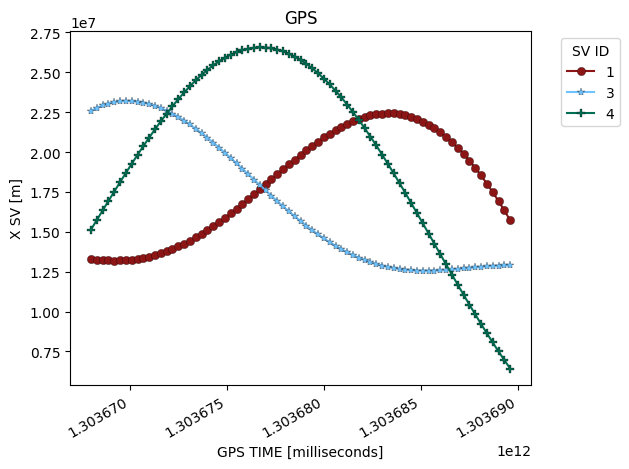

In [3]:
sp3_gps = sp3.where("gnss_id","gps")
figs = glp.plot_metric_by_constellation(
    sp3_gps.where("gnss_sv_id", ["G01","G04","G03"]),
    "gps_millis",
    "x_sv_m"
)

for i, fig in enumerate(figs):
    fig.savefig(f"GPS_ECEF_X_position_{i}.png", dpi=300)


In [4]:
DOP_MAX = 15.0  # anything above this is treated as invalid

def _safe(val):
    try:
        v = float(val)
        return v if np.isfinite(v) and v <= DOP_MAX else np.nan
    except Exception:
        return np.nan

def summary_visibility_PDOP_data(sp3_gnss, receiver_llh, elevation_mask_deg):
    # receiver ECEF
    rx_ecef = glp.geodetic_to_ecef(receiver_llh)

    # receiver state per measurement column
    t_all = sp3_gnss['gps_millis']
    rx = glp.NavData()
    rx['gps_millis'] = t_all
    rx['x_rx_m'] = np.full_like(t_all, float(rx_ecef[0,0]))
    rx['y_rx_m'] = np.full_like(t_all, float(rx_ecef[1,0]))
    rx['z_rx_m'] = np.full_like(t_all, float(rx_ecef[2,0]))

    # add el/az once (in-place)
    add_el_az(sp3_gnss, rx, inplace=True)

    # unique epochs
    u_t = np.unique(sp3_gnss['gps_millis'])

    # outputs
    summary = glp.NavData()
    summary['gps_millis'] = u_t
    num_vis = np.zeros(u_t.shape, dtype=int)
    pdop = np.full(u_t.shape, np.nan, dtype=float)
    hdop = np.full(u_t.shape, np.nan, dtype=float)
    vdop = np.full(u_t.shape, np.nan, dtype=float)
    gdop = np.full(u_t.shape, np.nan, dtype=float)

    for k, t in enumerate(u_t):
        nd = sp3_gnss.where('gps_millis', t)

        # elevation mask
        keep = np.where(nd['el_sv_deg'] >= elevation_mask_deg)[0]
        num_vis[k] = keep.size
        if keep.size == 0:
            continue

        nd_vis = nd.copy(cols=list(keep))

        # HDOP with >=3 sats
        if keep.size >= 3:
            try:
                d = get_dop(nd_vis, HDOP=True)
                hdop[k] = _safe(d['HDOP', 0])
            except Exception:
                hdop[k] = np.nan

        # Full 3D DOPs with >=4 sats
        if keep.size >= 4:
            try:
                d = get_dop(nd_vis, VDOP=True, PDOP=True, GDOP=True)
                vdop[k] = _safe(d['VDOP', 0])
                pdop[k] = _safe(d['PDOP', 0])
                gdop[k] = _safe(d['GDOP', 0])
            except Exception:
                vdop[k] = pdop[k] = gdop[k] = np.nan

    summary['num_visible_gps'] = num_vis
    summary['PDOP'] = pdop
    summary['HDOP'] = hdop
    summary['VDOP'] = vdop
    summary['GDOP'] = gdop
    return summary


In [5]:
sp3_gps.rows

['gps_millis', 'gnss_sv_id', 'gnss_id', 'sv_id', 'x_sv_m', 'y_sv_m', 'z_sv_m']

In [6]:
import matplotlib.pyplot as plt
import re

def save_fig_from_title(title):
    # sanitize title to be safe for filenames
    filename = re.sub(r'[^a-zA-Z0-9_\-]+', '_', title) + ".png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved figure as: {filename}")

def plot_visibility_PDOP_HDOP(summary, mask_deg=None):
    t = summary['gps_millis']
    if t.size == 0:
        return
    t_min = (t - t[0]) / 60000.0

    # Visible satellites
    plt.figure()
    plt.step(t_min, summary['num_visible_gps'], where='post')
    title = 'Visible GPS satellites vs time'
    if mask_deg is not None:
        title += f' (mask {mask_deg}°)'
    plt.title(title)
    plt.xlabel('Minutes since first epoch')
    plt.ylabel('Number of visible satellites')
    plt.grid(True)
    save_fig_from_title(title)
    plt.show()

    # PDOP
    plt.figure()
    plt.plot(t_min, summary['PDOP'], marker='.', linestyle='none')
    title = 'PDOP vs time'
    if mask_deg is not None:
        title += f' (mask {mask_deg}°)'
    plt.title(title)
    plt.xlabel('Minutes since first epoch')
    plt.ylabel('PDOP')
    plt.grid(True)
    save_fig_from_title(title)
    plt.show()

    # HDOP
    plt.figure()
    plt.plot(t_min, summary['HDOP'], marker='.', linestyle='none')
    title = 'HDOP vs time'
    if mask_deg is not None:
        title += f' (mask {mask_deg}°)'
    plt.title(title)
    plt.xlabel('Minutes since first epoch')
    plt.ylabel('HDOP')
    plt.grid(True)
    save_fig_from_title(title)
    plt.show()


def agg_plot_visibility_PDOP_HDOP(results):

    # Visible satellites comparison
    plt.figure()
    for e, s in results.items():
        t = s['gps_millis']
        if t.size == 0: 
            continue
        t_min = (t - t[0]) / 60000.0
        plt.step(t_min, s['num_visible_gps'], where='post', label=f'{e}°')
    title = 'Visible GPS satellites vs time (mask comparison)'
    plt.title(title)
    plt.xlabel('Minutes since first epoch')
    plt.ylabel('Number of visible satellites')
    plt.grid(True)
    plt.legend()
    save_fig_from_title(title)
    plt.show()
    
    # PDOP comparison
    plt.figure()
    for e, s in results.items():
        t = s['gps_millis']
        if t.size == 0: 
            continue
        t_min = (t - t[0]) / 60000.0
        plt.plot(t_min, s['PDOP'], marker='.', linestyle='none', label=f'{e}°')
    title = 'PDOP vs time (mask comparison)'
    plt.title(title)
    plt.xlabel('Minutes since first epoch')
    plt.ylabel('PDOP')
    plt.grid(True)
    plt.legend()
    save_fig_from_title(title)
    plt.show()
    
    # HDOP comparison
    plt.figure()
    for e, s in results.items():
        t = s['gps_millis']
        if t.size == 0: 
            continue
        t_min = (t - t[0]) / 60000.0
        plt.plot(t_min, s['HDOP'], marker='.', linestyle='none', label=f'{e}°')
    title = 'HDOP vs time (mask comparison)'
    plt.title(title)
    plt.xlabel('Minutes since first epoch')
    plt.ylabel('HDOP')
    plt.grid(True)
    plt.legend()
    save_fig_from_title(title)
    plt.show()


Saved figure as: Visible_GPS_satellites_vs_time_mask_10_.png


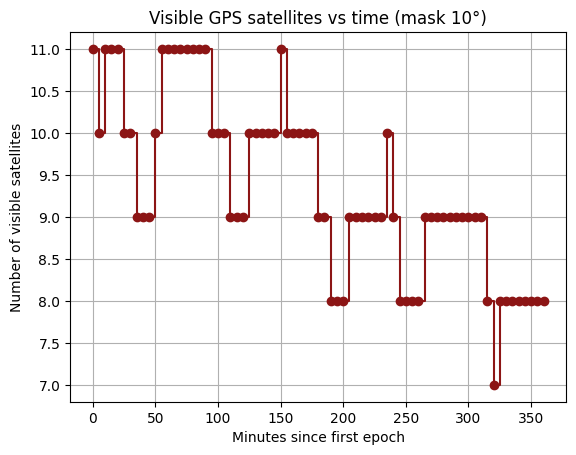

Saved figure as: PDOP_vs_time_mask_10_.png


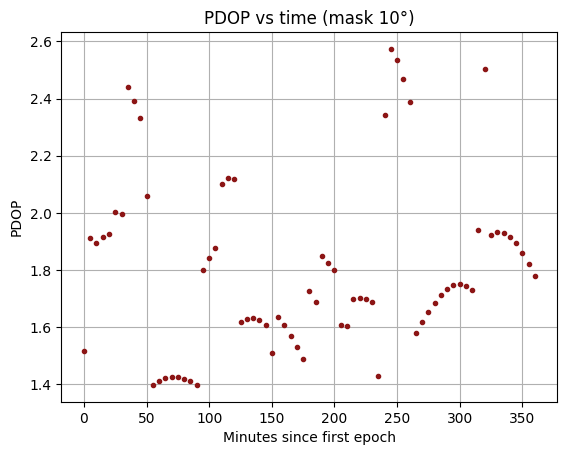

Saved figure as: HDOP_vs_time_mask_10_.png


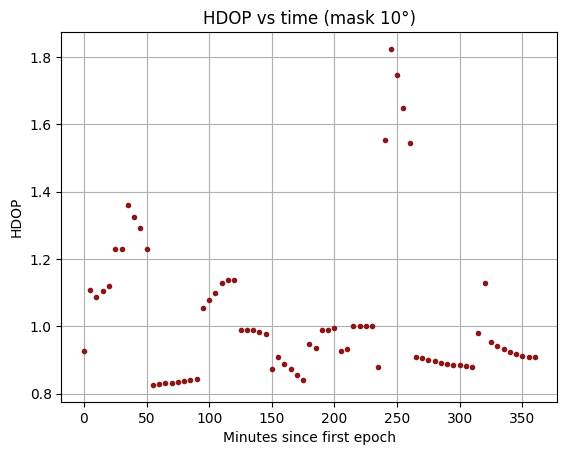

Saved figure as: Visible_GPS_satellites_vs_time_mask_15_.png


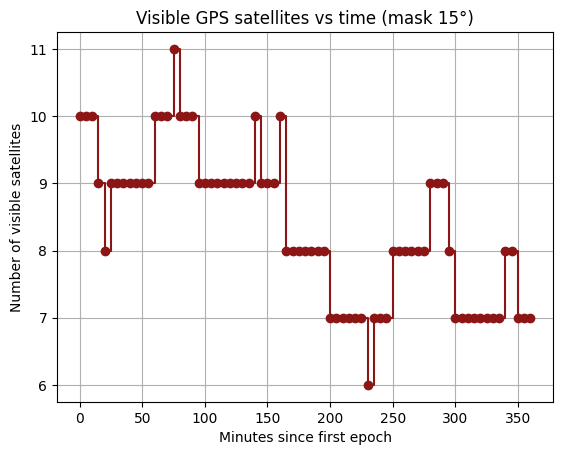

Saved figure as: PDOP_vs_time_mask_15_.png


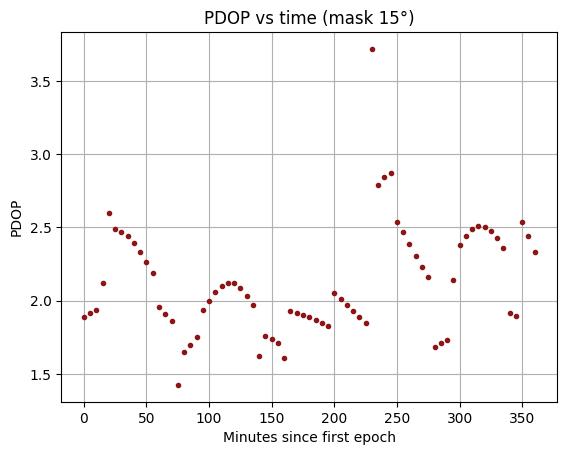

Saved figure as: HDOP_vs_time_mask_15_.png


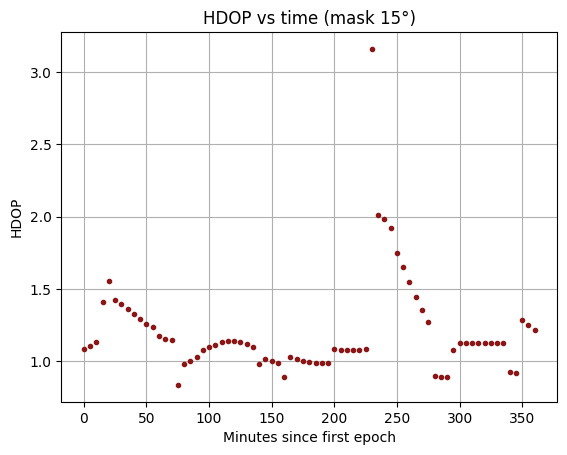

Saved figure as: Visible_GPS_satellites_vs_time_mask_20_.png


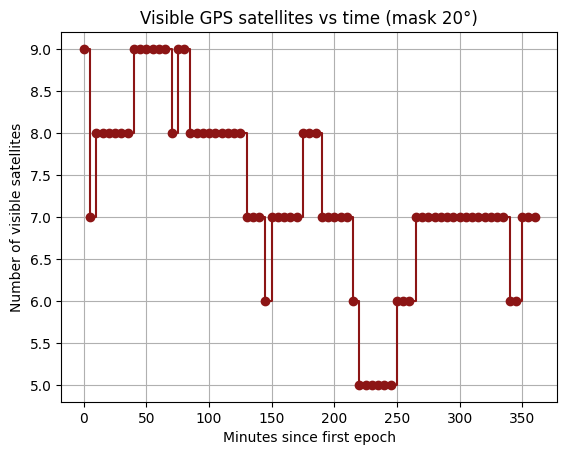

Saved figure as: PDOP_vs_time_mask_20_.png


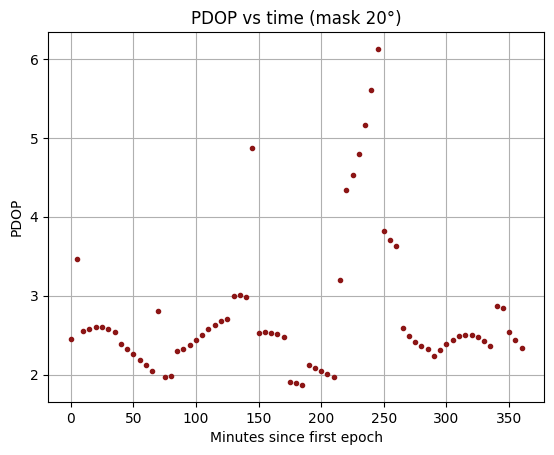

Saved figure as: HDOP_vs_time_mask_20_.png


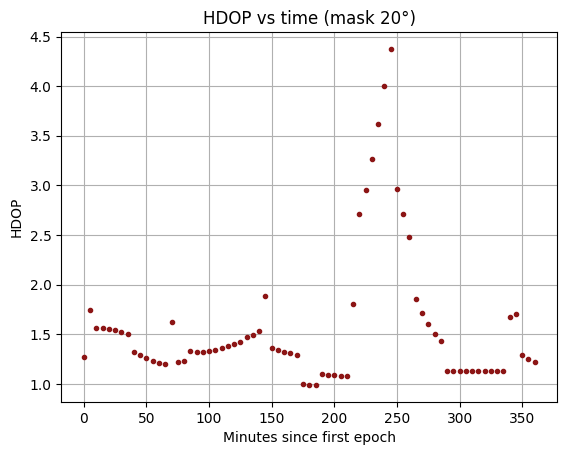

Saved figure as: Visible_GPS_satellites_vs_time_mask_30_.png


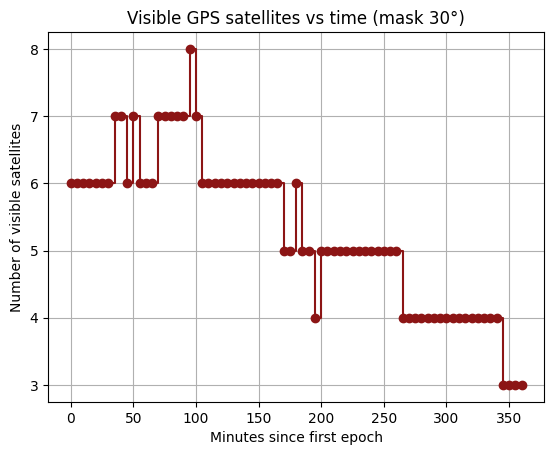

Saved figure as: PDOP_vs_time_mask_30_.png


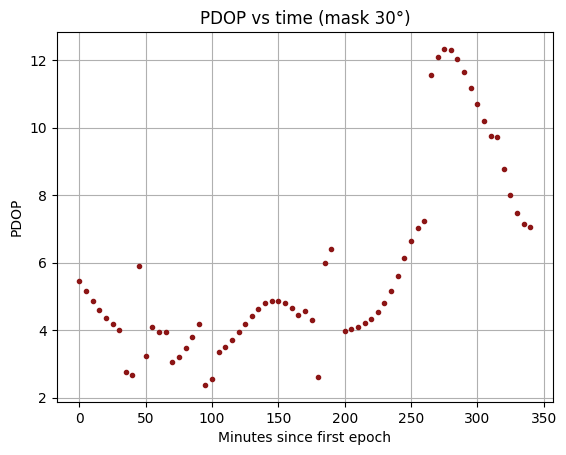

Saved figure as: HDOP_vs_time_mask_30_.png


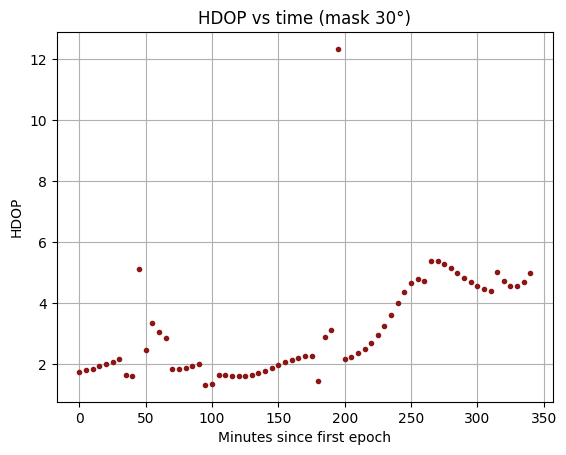

Saved figure as: Visible_GPS_satellites_vs_time_mask_40_.png


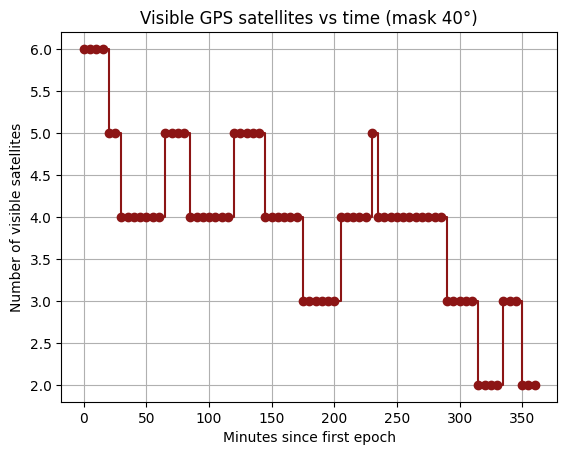

Saved figure as: PDOP_vs_time_mask_40_.png


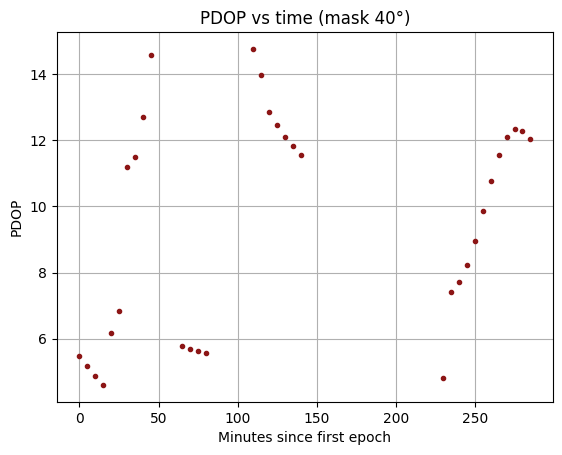

Saved figure as: HDOP_vs_time_mask_40_.png


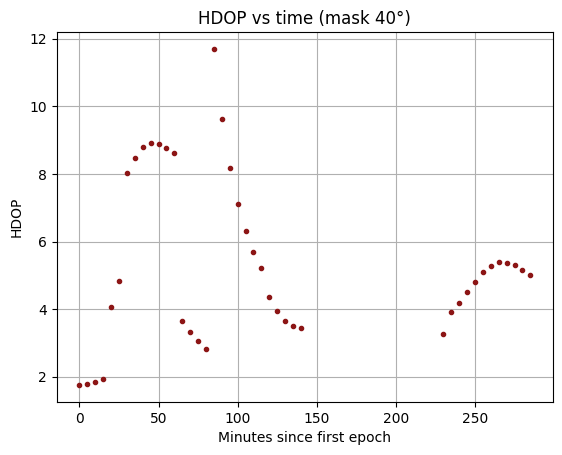

Saved figure as: Visible_GPS_satellites_vs_time_mask_50_.png


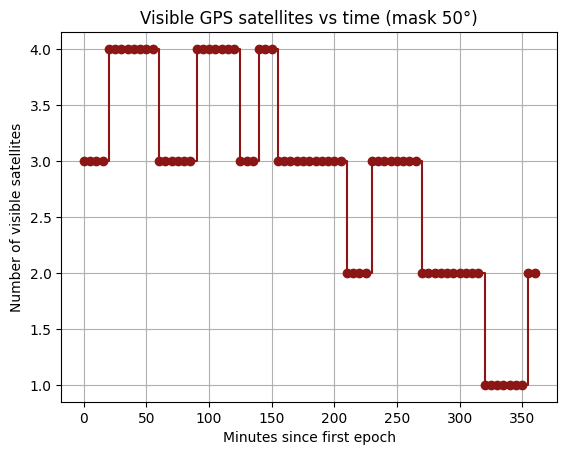

Saved figure as: PDOP_vs_time_mask_50_.png


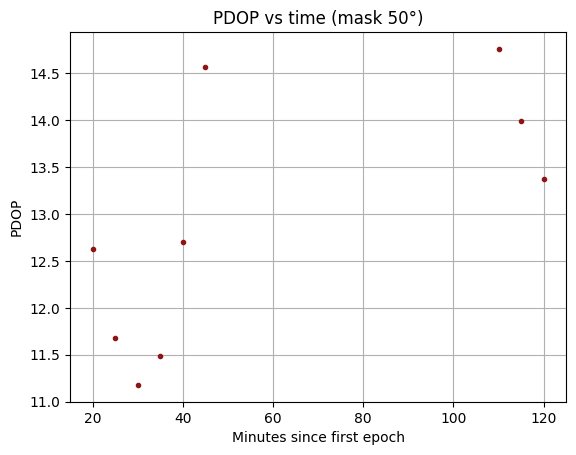

Saved figure as: HDOP_vs_time_mask_50_.png


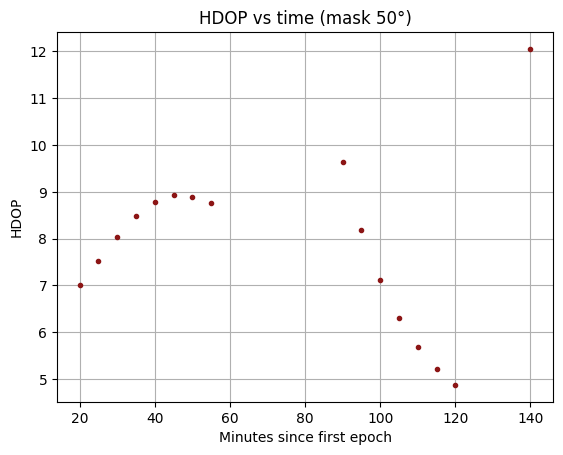

Saved figure as: Visible_GPS_satellites_vs_time_mask_60_.png


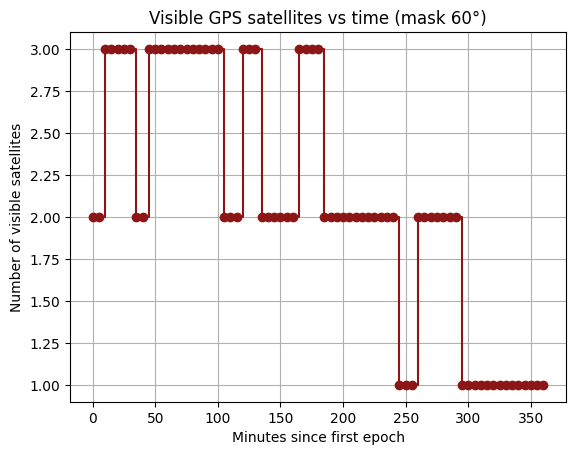

Saved figure as: PDOP_vs_time_mask_60_.png


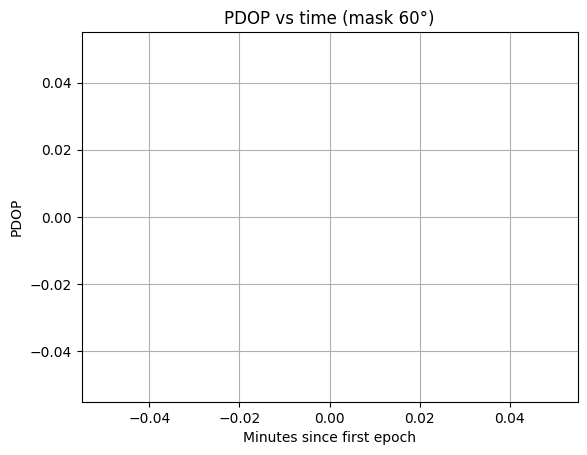

Saved figure as: HDOP_vs_time_mask_60_.png


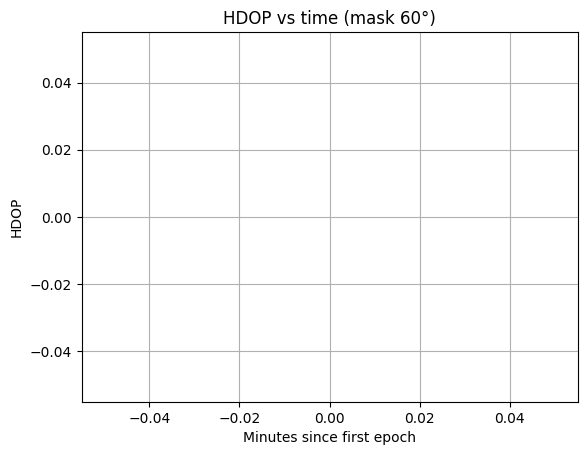

In [7]:
# Montreal location
rx_llh = np.array([[45.5017], [-73.5673], [30.0]])

elevation_mask = [10,15,20,30,40,50,60]

for e in elevation_mask:
    summary = summary_visibility_PDOP_data(sp3_gps, rx_llh, e)
    plot_visibility_PDOP_HDOP(summary, mask_deg=e)

Saved figure as: Visible_GPS_satellites_vs_time_mask_comparison_.png


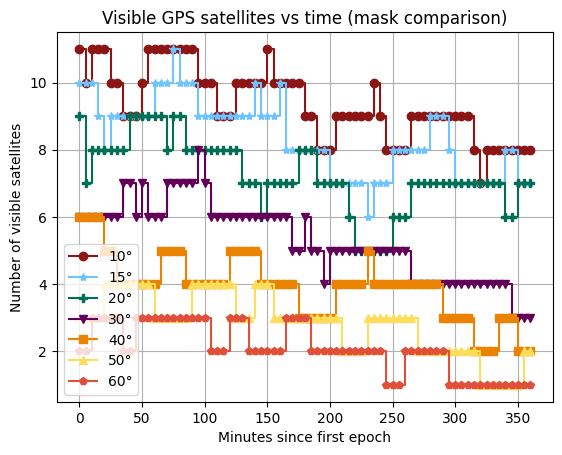

Saved figure as: PDOP_vs_time_mask_comparison_.png


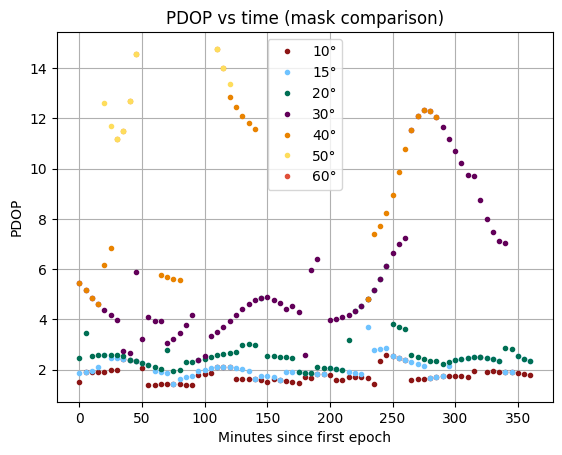

Saved figure as: HDOP_vs_time_mask_comparison_.png


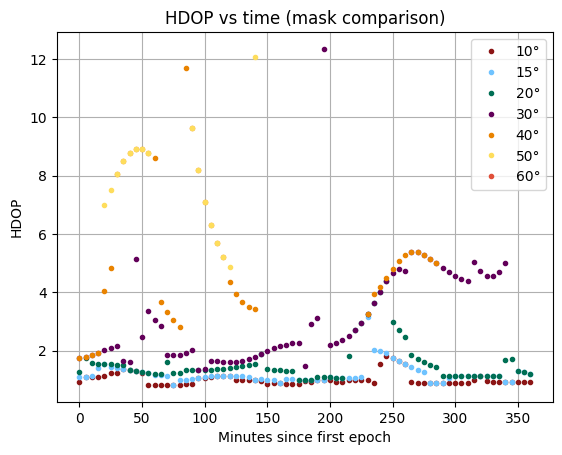

In [8]:
results = {}
elevation_mask = [10,15,20,30,40,50,60]
for e in elevation_mask:
    results[e] = summary_visibility_PDOP_data(sp3_gps, rx_llh, e)

agg_plot_visibility_PDOP_HDOP(results)

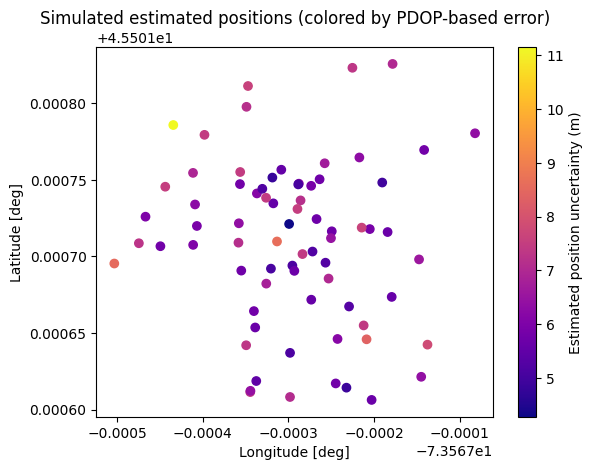

In [9]:
true_llh = np.array([[45.5017], [-73.5673], [30.0]])  # Montreal
true_ecef = glp.geodetic_to_ecef(true_llh)

summary = summary_visibility_PDOP_data(sp3_gps, true_llh, 15)


sigma_range = 3.0  # assumed range error (m)
sigma_pos = summary['PDOP'] * sigma_range

# Add random noise scaled by PDOP to simulate "estimated positions"
np.random.seed(0)
x_est = true_ecef[0] + np.random.randn(len(sigma_pos)) * sigma_pos
y_est = true_ecef[1] + np.random.randn(len(sigma_pos)) * sigma_pos
z_est = true_ecef[2] + np.random.randn(len(sigma_pos)) * sigma_pos

est_llh = glp.ecef_to_geodetic(np.vstack([x_est, y_est, z_est]))

plt.figure()
plt.scatter(est_llh[1, :], est_llh[0, :], c=sigma_pos, cmap='plasma')
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
plt.title('Simulated estimated positions (colored by PDOP-based error)')
plt.colorbar(label='Estimated position uncertainty (m)')
plt.show()

In [18]:
LEO_CSV = "outputs/starlink_navdata_leo_aligned_1000.csv"
LEO_CSV = "outputs/starlink_navdata_leo_aligned_3000.csv"

# LEO_CSV = "outputs/starlink_navdata_leo_aligned_6000.csv"

df_leo = pd.read_csv(LEO_CSV)
# Convert to NavData
leo = glp.NavData()

for col in df_leo.columns:
    leo[col] = df_leo[col].to_numpy().reshape(-1, 1)
    
print("LEO NavData rows:", leo.rows)

LEO NavData rows: ['gps_millis', 'gnss_sv_id', 'gnss_id', 'sv_id', 'x_sv_m', 'y_sv_m', 'z_sv_m', 'el_sv_deg', 'az_sv_deg']


In [19]:
merged = glp.concat(sp3_gps, leo, axis=1)
print("Merged NavData rows:", merged)

Merged NavData rows:           gps_millis      gnss_sv_id gnss_id  sv_id        x_sv_m  \
0       1.303668e+12             G01     gps      1  1.328768e+07   
1       1.303668e+12             G02     gps      2 -1.344951e+07   
2       1.303668e+12             G03     gps      3  2.258999e+07   
3       1.303668e+12             G04     gps      4  1.514119e+07   
4       1.303668e+12             G05     gps      5 -2.431371e+07   
...              ...             ...     ...    ...           ...   
221258  1.303690e+12  STARLINK-56783     LEO  56783  2.578192e+06   
221259  1.303690e+12  STARLINK-56784     LEO  56784 -1.986363e+06   
221260  1.303690e+12  STARLINK-56785     LEO  56785 -2.754725e+06   
221261  1.303690e+12  STARLINK-56786     LEO  56786 -2.726693e+06   
221262  1.303690e+12  STARLINK-56787     LEO  56787  3.204512e+06   

              y_sv_m        z_sv_m  el_sv_deg   az_sv_deg  
0      -1.549193e+07  1.654569e+07  65.237397  101.238654  
1      -9.668544e+06 -2.010071

Saved figure as: Visible_GPS_satellites_vs_time_mask_comparison_.png


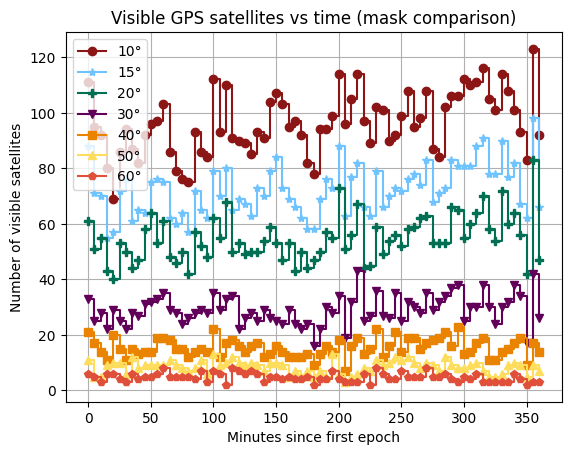

Saved figure as: PDOP_vs_time_mask_comparison_.png


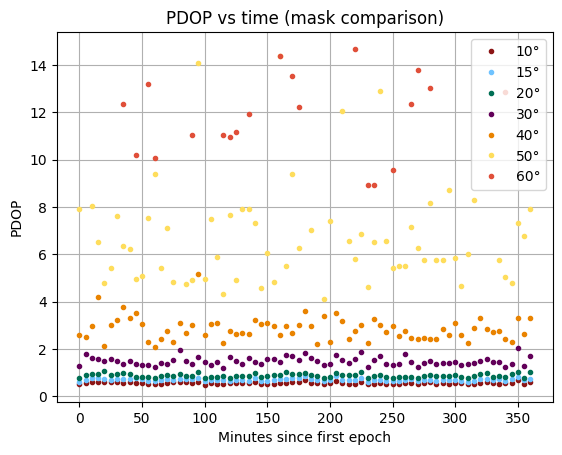

Saved figure as: HDOP_vs_time_mask_comparison_.png


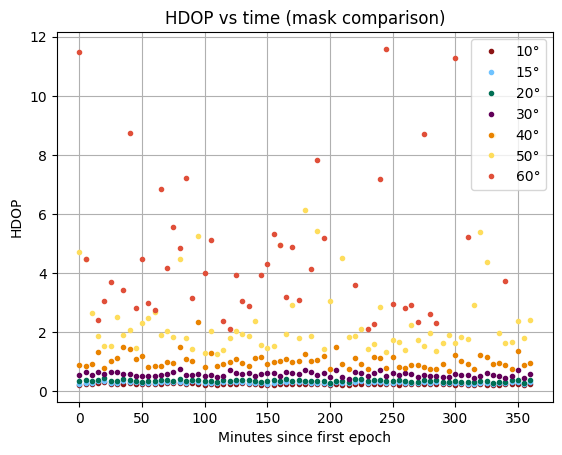

In [20]:
results = {}
elevation_mask = [10,15,20,30,40,50,60]
for e in elevation_mask:
    results[e] = summary_visibility_PDOP_data(merged, rx_llh, e)

agg_plot_visibility_PDOP_HDOP(results)

Saved figure as: Visible_GPS_satellites_vs_time_mask_50_.png


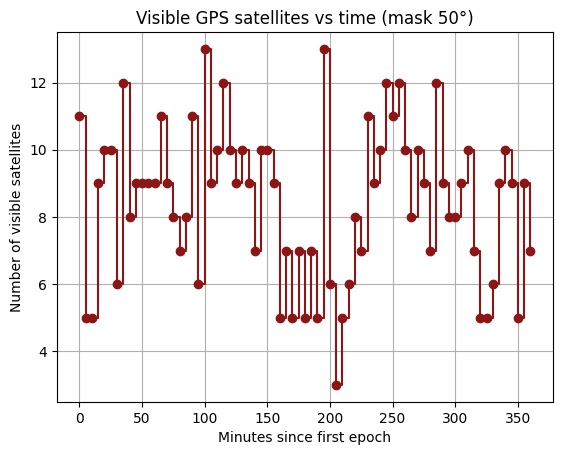

Saved figure as: PDOP_vs_time_mask_50_.png


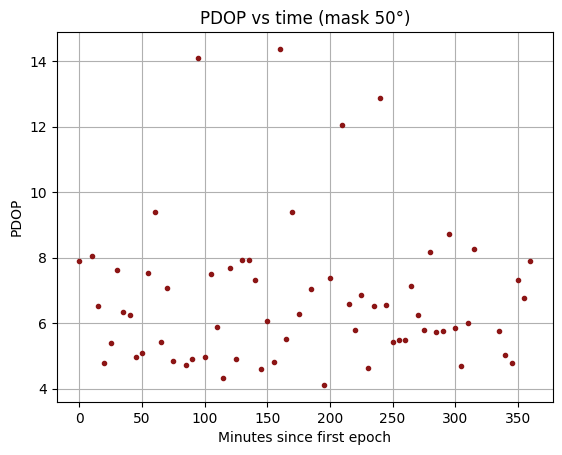

Saved figure as: HDOP_vs_time_mask_50_.png


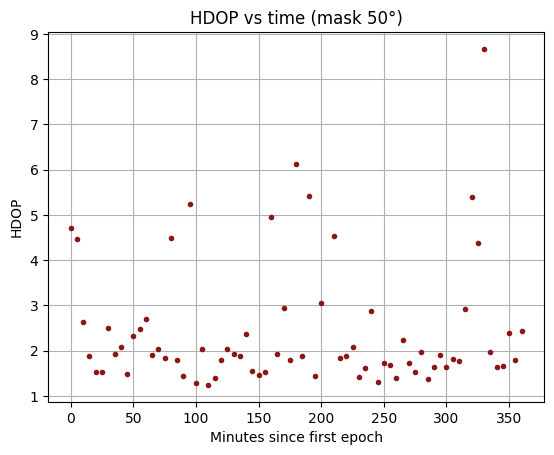

Saved figure as: Visible_GPS_satellites_vs_time_mask_60_.png


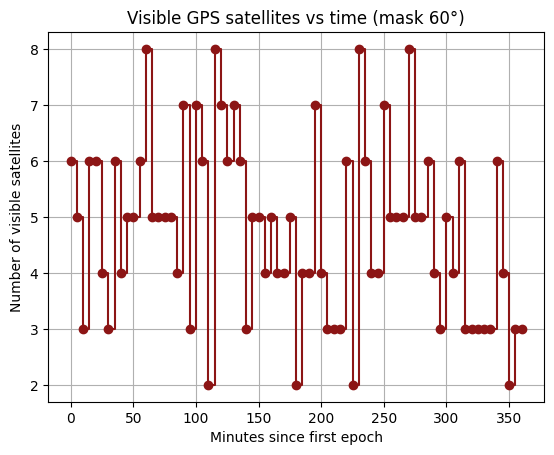

Saved figure as: PDOP_vs_time_mask_60_.png


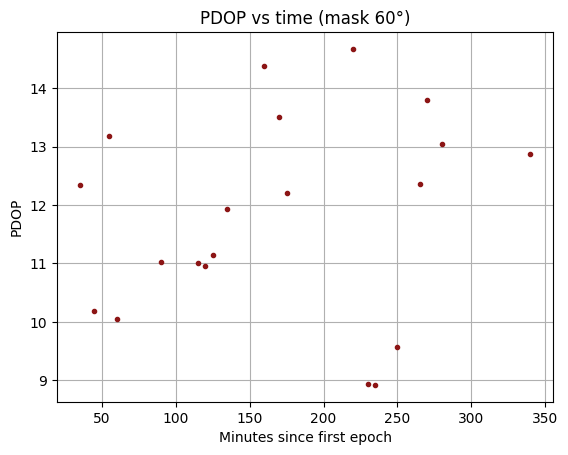

Saved figure as: HDOP_vs_time_mask_60_.png


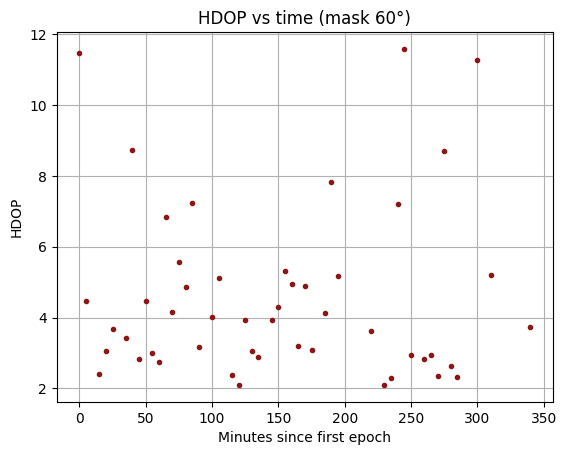

In [21]:
# Montreal location
rx_llh = np.array([[45.5017], [-73.5673], [30.0]])

elevation_mask = [50,60]

for e in elevation_mask:
    summary = summary_visibility_PDOP_data(merged, rx_llh, e)
    plot_visibility_PDOP_HDOP(summary, mask_deg=e)

In [ ]:
print("Merged NavData rows:", merged)

In [ ]:
np.unique(leo['gnss_sv_id']).size